In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# ----------------------------
# Config
# ----------------------------
OUTPUT_DIR = "sensor_data_1GB"
os.makedirs(OUTPUT_DIR, exist_ok=True)

TARGET_SIZE_GB = 1.0          # minimum size on disk
ROWS_PER_CHUNK = 1_000_000    # adjust based on RAM
FILE_BASENAME = "sensor_maintenance_chunk"

# Time and sensor configuration
START_TIME = datetime(2024, 1, 1)
FREQ_HOURS = 1                # hourly data
HOURS_PER_SENSOR = 24 * 60    # 60 days per sensor
SENSORS_PER_BATCH = 50        # sensors per chunk (tune as needed)

np.random.seed(42)

# Fixed categorical value spaces
OPERATIONAL_STATUSES = ["Operational", "Under Maintenance"]
FAULT_STATUSES = ["No Fault", "Fault Detected"]
FAILURE_TYPES = ["None", "Overload", "Overheating"]
MAINTENANCE_TYPES = ["Preventive", "Corrective"]
FAILURE_HISTORY_TYPES = ["No Fault", "Fault Detected"]
EXTERNAL_FACTORS = ["Clear Weather", "Storm"]
EQUIPMENT_REL = ["Independent", "Dependent"]
EQUIPMENT_CRIT = ["High", "Medium"]

# ----------------------------
# Helpers
# ----------------------------

def get_total_size_gb(path):
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            total += os.path.getsize(os.path.join(root, f))
    return total / (1024 ** 3)

def simulate_one_sensor(sensor_idx):
    """
    Simulate time-series for one sensor in the same column format.
    """
    n = HOURS_PER_SENSOR
    timestamps = [START_TIME + timedelta(hours=i) for i in range(n)]

    sensor_id = f"S_{sensor_idx}"
    equipment_id = f"E_{sensor_idx}"

    # Electrical
    base_voltage = 110 + (sensor_idx % 10)
    voltage = base_voltage + np.random.randint(-2, 3, size=n)

    current = 0.5 + 0.1 * np.sin(np.linspace(0, 4 * np.pi, n)) + np.random.normal(0, 0.05, n)
    current = np.round(np.clip(current, 0.3, 1.5), 2)

    temperature = 20 + np.linspace(0, 10, n) / 10 + np.random.normal(0, 1.0, n)
    temperature = np.round(temperature, 1)

    power = np.round(voltage * current, 1)

    humidity = 40 + np.sin(np.linspace(0, 2 * np.pi, n)) * 5 + np.random.normal(0, 2, n)
    humidity = np.round(np.clip(humidity, 20, 90), 0)

    vibration = 0.2 + 0.05 * np.sin(np.linspace(0, 6 * np.pi, n)) + np.random.normal(0, 0.02, n)
    vibration = np.round(np.clip(vibration, 0.1, 1.5), 3)

    # Operational status
    operational_status = np.random.choice(OPERATIONAL_STATUSES, size=n, p=[0.7, 0.3])

    # Faults correlated with vibration and temperature
    fault_prob = np.clip((vibration - 0.25) * 8 + (temperature - 25) * 0.03, 0, 0.8)
    fault_detected_bin = (np.random.rand(n) < fault_prob).astype(int)

    fault_status = np.where(
        fault_detected_bin == 1,
        "Fault Detected",
        "No Fault"
    )

    failure_type_choices = [ft for ft in FAILURE_TYPES if ft != "None"]
    failure_type = np.where(
        fault_detected_bin == 1,
        np.random.choice(failure_type_choices, size=n),
        "None"
    )

    # Maintenance pattern: every 200 hours
    last_maint_dates = []
    last_maint = START_TIME
    for i in range(n):
        if i % 200 == 0 and i != 0:
            last_maint = timestamps[i]
        last_maint_dates.append(last_maint.date().isoformat())

    maintenance_type = np.random.choice(MAINTENANCE_TYPES, size=n, p=[0.6, 0.4])

    failure_history = np.where(
        fault_detected_bin == 1,
        "Fault Detected",
        "No Fault"
    )

    repair_time = np.where(
        fault_detected_bin == 1,
        np.random.randint(1, 10, size=n),
        0
    )

    maintenance_costs = np.where(
        fault_detected_bin == 1,
        np.random.randint(150, 300, size=n),
        np.random.randint(100, 220, size=n)
    )

    # Ambient & context
    ambient_temp = np.round(20 + np.sin(np.linspace(0, 2 * np.pi, n)) * 5 + np.random.normal(0, 1, n), 1)
    ambient_humidity = 40 + np.sin(np.linspace(0, 4 * np.pi, n)) * 10 + np.random.normal(0, 3, n)
    ambient_humidity = np.round(np.clip(ambient_humidity, 20, 95), 0)

    external_factors = np.random.choice(EXTERNAL_FACTORS, size=n)

    # Position
    X = np.random.randint(0, 50, size=n)
    Y = np.random.randint(0, 50, size=n)
    Z = np.random.randint(0, 50, size=n)

    equipment_relationship = np.random.choice(EQUIPMENT_REL, size=n)
    equipment_criticality = np.random.choice(EQUIPMENT_CRIT, size=n, p=[0.6, 0.4])

    predictive_trigger = fault_detected_bin.copy()

    df = pd.DataFrame({
        "Sensor_ID": [sensor_id] * n,
        "Timestamp": timestamps,
        "Voltage (V)": voltage,
        "Current (A)": current,
        "Temperature (°C)": temperature,
        "Power (W)": power,
        "Humidity (%)": humidity,
        "Vibration (m/s²)": vibration,
        "Equipment_ID": [equipment_id] * n,
        "Operational Status": operational_status,
        "Fault Status": fault_status,
        "Failure Type": failure_type,
        "Last Maintenance Date": last_maint_dates,
        "Maintenance Type": maintenance_type,
        "Failure History": failure_history,
        "Repair Time (hrs)": repair_time,
        "Maintenance Costs (USD)": maintenance_costs,
        "Ambient Temperature (°C)": ambient_temp,
        "Ambient Humidity (%)": ambient_humidity,
        "External Factors": external_factors,
        "X": X,
        "Y": Y,
        "Z": Z,
        "Equipment Relationship": equipment_relationship,
        "Equipment Criticality": equipment_criticality,
        "Fault Detected": fault_detected_bin,
        "Predictive Maintenance Trigger": predictive_trigger,
    })
    return df

# ----------------------------
# Streaming generation to reach ≥ 1 GB
# ----------------------------
chunk_index = 0
sensor_global_index = 1

while True:
    dfs = []
    for _ in range(SENSORS_PER_BATCH):
        df_s = simulate_one_sensor(sensor_global_index)
        dfs.append(df_s)
        sensor_global_index += 1

    chunk_df = pd.concat(dfs, ignore_index=True)

    # Optional: sort for nicer structure
    chunk_df.sort_values(["Timestamp", "Sensor_ID"], inplace=True)

    out_path = os.path.join(OUTPUT_DIR, f"{FILE_BASENAME}_{chunk_index:03d}.csv")
    chunk_df.to_csv(out_path, index=False)
    chunk_index += 1

    current_size = get_total_size_gb(OUTPUT_DIR)
    print(f"Wrote {out_path} with {len(chunk_df)} rows. Total size ≈ {current_size:.2f} GB")

    if current_size >= TARGET_SIZE_GB:
        print("Reached target size; stopping.")
        break


Wrote sensor_data_1GB\sensor_maintenance_chunk_000.csv with 72000 rows. Total size ≈ 1.99 GB
Reached target size; stopping.


In [2]:
import os
import pandas as pd
from glob import glob

# Folder where your chunk files are stored
folder_path = os.path.join(os.getcwd(), "sensor_data_1GB")

# Pattern to match all chunk CSVs
csv_files = sorted(glob(os.path.join(folder_path, "sensor_maintenance_chunk_*.csv")))

print("Number of files to merge:", len(csv_files))

# Output path for the combined CSV
output_path = os.path.join(folder_path, "sensor_maintenance_combined.csv")

# If the combined file already exists, remove it (optional)
if os.path.exists(output_path):
    os.remove(output_path)

# Read and append in chunks to avoid high memory usage
first = True
for i, f in enumerate(csv_files, start=1):
    print(f"Processing {i}/{len(csv_files)}: {f}")
    chunk_df = pd.read_csv(f)

    # Write header only for the first file
    if first:
        chunk_df.to_csv(output_path, index=False, mode="w", header=True)
        first = False
    else:
        chunk_df.to_csv(output_path, index=False, mode="a", header=False)

print("Combined file saved at:", output_path)


Number of files to merge: 84
Processing 1/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_000.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 2/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_001.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 3/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_002.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 4/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_003.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 5/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_004.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 6/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_005.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 7/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_006.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 8/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_007.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 9/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_008.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 10/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_009.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 11/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_010.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 12/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_011.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 13/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_012.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 14/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_013.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 15/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_014.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 16/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_015.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 17/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_016.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 18/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_017.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 19/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_018.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 20/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_019.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 21/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_020.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 22/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_021.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 23/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_022.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 24/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_023.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 25/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_024.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 26/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_025.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 27/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_026.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 28/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_027.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 29/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_028.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 30/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_029.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 31/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_030.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 32/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_031.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 33/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_032.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 34/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_033.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 35/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_034.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 36/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_035.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 37/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_036.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 38/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_037.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 39/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_038.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 40/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_039.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 41/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_040.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 42/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_041.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 43/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_042.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 44/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_043.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 45/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_044.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 46/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_045.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 47/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_046.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 48/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_047.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 49/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_048.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 50/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_049.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 51/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_050.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 52/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_051.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 53/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_052.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 54/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_053.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 55/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_054.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 56/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_055.csv
Processing 57/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_056.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 58/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_057.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 59/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_058.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 60/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_059.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 61/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_060.csv
Processing 62/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_061.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 63/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_062.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 64/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_063.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 65/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_064.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 66/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_065.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 67/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_066.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 68/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_067.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 69/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_068.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 70/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_069.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 71/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_070.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 72/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_071.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 73/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_072.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 74/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_073.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 75/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_074.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 76/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_075.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 77/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_076.csv
Processing 78/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_077.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 79/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_078.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 80/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_079.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 81/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_080.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 82/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_081.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 83/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_082.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Processing 84/84: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_chunk_083.csv


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1975085544.py:24: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(f)


Combined file saved at: C:\Users\mihir\sensor_data_1GB\sensor_maintenance_combined.csv


In [3]:
import os
import pandas as pd
import numpy as np

# Set the path to your combined CSV
folder_path = os.path.join(os.getcwd(), "sensor_data_1GB")
combined_path = os.path.join(folder_path, "sensor_maintenance_combined.csv")

# Use low_memory=False for mixed-type columns
df = pd.read_csv(combined_path, low_memory=False)

print("Shape (rows, columns):", df.shape)
print("\nColumns:\n", df.columns.tolist())


Shape (rows, columns): (6048000, 27)

Columns:
 ['Sensor_ID', 'Timestamp', 'Voltage (V)', 'Current (A)', 'Temperature (°C)', 'Power (W)', 'Humidity (%)', 'Vibration (m/s²)', 'Equipment_ID', 'Operational Status', 'Fault Status', 'Failure Type', 'Last Maintenance Date', 'Maintenance Type', 'Failure History', 'Repair Time (hrs)', 'Maintenance Costs (USD)', 'Ambient Temperature (°C)', 'Ambient Humidity (%)', 'External Factors', 'X', 'Y', 'Z', 'Equipment Relationship', 'Equipment Criticality', 'Fault Detected', 'Predictive Maintenance Trigger']


In [4]:
# 2.1 dtypes
print("Data types:\n")
print(df.dtypes)

# 2.2 Missing values
missing = df.isna().sum().to_frame("missing_count")
missing["missing_pct"] = (missing["missing_count"] / len(df)) * 100
missing.sort_values("missing_pct", ascending=False, inplace=True)
missing.head(30)


Data types:

Sensor_ID                          object
Timestamp                          object
Voltage (V)                         int64
Current (A)                       float64
Temperature (°C)                  float64
Power (W)                         float64
Humidity (%)                      float64
Vibration (m/s²)                  float64
Equipment_ID                       object
Operational Status                 object
Fault Status                       object
Failure Type                       object
Last Maintenance Date              object
Maintenance Type                   object
Failure History                    object
Repair Time (hrs)                   int64
Maintenance Costs (USD)             int64
Ambient Temperature (°C)          float64
Ambient Humidity (%)              float64
External Factors                   object
X                                   int64
Y                                   int64
Z                                   int64
Equipment Relationshi

,missing_count,missing_pct
Failure Type,6028129,99.671445
Timestamp,0,0.000000
Sensor_ID,0,0.000000
Current (A),0,0.000000
Temperature (°C),0,0.000000
Power (W),0,0.000000
Humidity (%),0,0.000000
Vibration (m/s²),0,0.000000
Equipment_ID,0,0.000000
Operational Status,0,0.000000


In [5]:
# 2.3 Basic numeric stats
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_summary = df[numeric_cols].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).T
numeric_summary


,count,mean,std,min,1%,25%,50%,75%,99%,max
Voltage (V),6048000.0,114.500240,3.201959,108.0,108.000,112.000,115.0,117.000,121.000,121.000
Current (A),6048000.0,0.500065,0.086455,0.3,0.320,0.430,0.5,0.570,0.680,0.830
Temperature (°C),6048000.0,20.499838,1.041055,15.2,18.100,19.800,20.5,21.200,22.900,25.900
Power (W),6048000.0,57.257858,10.031762,32.4,36.300,49.600,57.2,65.000,78.600,97.600
Humidity (%),6048000.0,39.999270,4.072602,25.0,32.000,37.000,40.0,43.000,48.000,54.000
Vibration (m/s²),6048000.0,0.200009,0.040590,0.1,0.119,0.167,0.2,0.233,0.281,0.338
Repair Time (hrs),6048000.0,0.016329,0.320726,0.0,0.000,0.000,0.0,0.000,0.000,9.000
Maintenance Costs (USD),6048000.0,159.708628,34.874776,100.0,101.000,130.000,160.0,190.000,219.000,299.000
Ambient Temperature (°C),6048000.0,19.999946,3.673470,10.4,13.600,16.600,20.0,23.400,26.400,29.800
Ambient Humidity (%),6048000.0,39.998827,7.684595,20.0,26.000,33.000,40.0,47.000,55.000,65.000


In [6]:
# 2.4 Categorical stats
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_summary = {}

for c in cat_cols:
    vc = df[c].value_counts(dropna=False)
    cat_summary[c] = {
        "n_unique": df[c].nunique(dropna=False),
        "top_values": vc.head(5).to_dict()
    }

cat_summary


{'Sensor_ID': {'n_unique': 4200,
  'top_values': {'S_4200': 1440,
   'S_1': 1440,
   'S_10': 1440,
   'S_11': 1440,
   'S_12': 1440}},
 'Timestamp': {'n_unique': 1440,
  'top_values': {'2024-02-28 08:00:00': 4200,
   '2024-02-28 09:00:00': 4200,
   '2024-02-28 10:00:00': 4200,
   '2024-02-28 11:00:00': 4200,
   '2024-02-28 12:00:00': 4200}},
 'Equipment_ID': {'n_unique': 4200,
  'top_values': {'E_4200': 1440,
   'E_1': 1440,
   'E_10': 1440,
   'E_11': 1440,
   'E_12': 1440}},
 'Operational Status': {'n_unique': 2,
  'top_values': {'Operational': 4230910, 'Under Maintenance': 1817090}},
 'Fault Status': {'n_unique': 2,
  'top_values': {'No Fault': 6028129, 'Fault Detected': 19871}},
 'Failure Type': {'n_unique': 3,
  'top_values': {nan: 6028129, 'Overheating': 9958, 'Overload': 9913}},
 'Last Maintenance Date': {'n_unique': 8,
  'top_values': {'2024-01-01': 840000,
   '2024-01-09': 840000,
   '2024-01-17': 840000,
   '2024-01-26': 840000,
   '2024-02-03': 840000}},
 'Maintenance Type':

In [7]:
# 2.5 Check physically reasonable ranges for key sensors
checks = {}

def range_check(col, low, high):
    if col in df.columns:
        bad = df[(df[col] < low) | (df[col] > high)]
        checks[col] = {
            "low": low,
            "high": high,
            "n_out_of_range": len(bad),
            "pct_out_of_range": (len(bad) / len(df)) * 100
        }

range_check("Voltage (V)", 80, 260)
range_check("Current (A)", 0, 100)
range_check("Temperature (°C)", -40, 120)
range_check("Humidity (%)", 0, 100)
range_check("Vibration (m/s²)", 0, 50)
range_check("Ambient Temperature (°C)", -40, 120)
range_check("Ambient Humidity (%)", 0, 100)
checks


{'Voltage (V)': {'low': 80,
  'high': 260,
  'n_out_of_range': 0,
  'pct_out_of_range': 0.0},
 'Current (A)': {'low': 0,
  'high': 100,
  'n_out_of_range': 0,
  'pct_out_of_range': 0.0},
 'Temperature (°C)': {'low': -40,
  'high': 120,
  'n_out_of_range': 0,
  'pct_out_of_range': 0.0},
 'Humidity (%)': {'low': 0,
  'high': 100,
  'n_out_of_range': 0,
  'pct_out_of_range': 0.0},
 'Vibration (m/s²)': {'low': 0,
  'high': 50,
  'n_out_of_range': 0,
  'pct_out_of_range': 0.0},
 'Ambient Temperature (°C)': {'low': -40,
  'high': 120,
  'n_out_of_range': 0,
  'pct_out_of_range': 0.0},
 'Ambient Humidity (%)': {'low': 0,
  'high': 100,
  'n_out_of_range': 0,
  'pct_out_of_range': 0.0}}

In [8]:
# 2.6 Time coverage and sampling check
if "Timestamp" in df.columns:
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    print("Time range:", df["Timestamp"].min(), "→", df["Timestamp"].max())
    # Per-sensor row counts
    if "Sensor_ID" in df.columns:
        print(df.groupby("Sensor_ID")["Timestamp"].agg(["min", "max", "count"]).head())


Time range: 2024-01-01 00:00:00 → 2024-02-29 23:00:00
                 min                 max  count
Sensor_ID                                      
S_1       2024-01-01 2024-02-29 23:00:00   1440
S_10      2024-01-01 2024-02-29 23:00:00   1440
S_100     2024-01-01 2024-02-29 23:00:00   1440
S_1000    2024-01-01 2024-02-29 23:00:00   1440
S_1001    2024-01-01 2024-02-29 23:00:00   1440


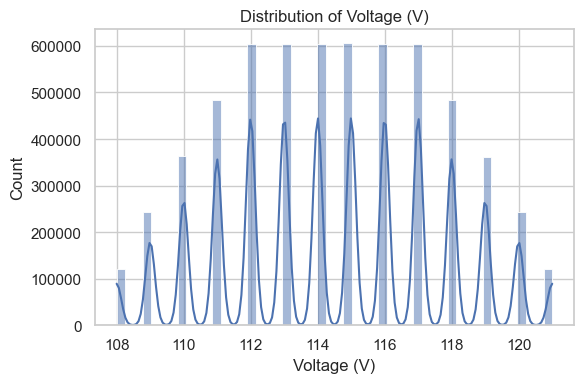

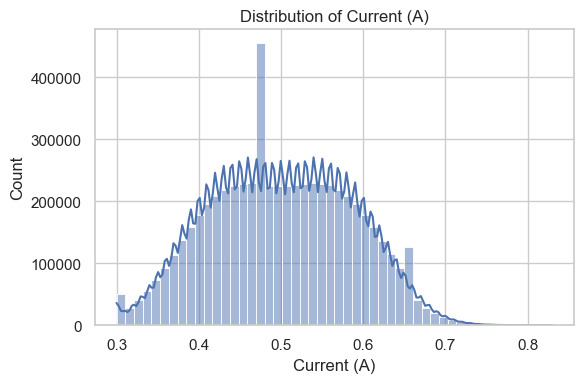

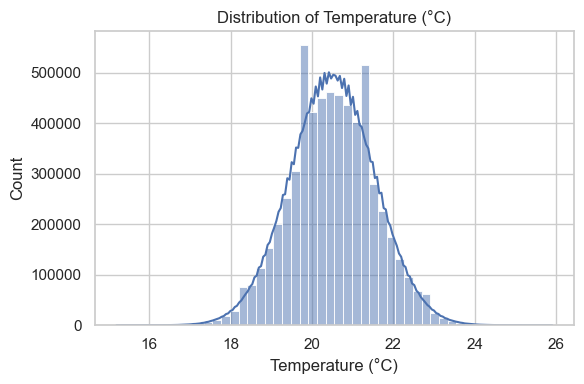

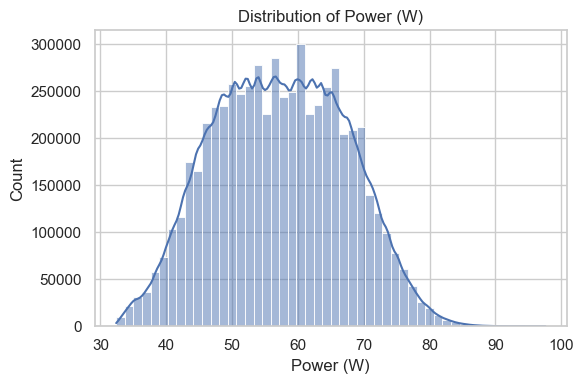

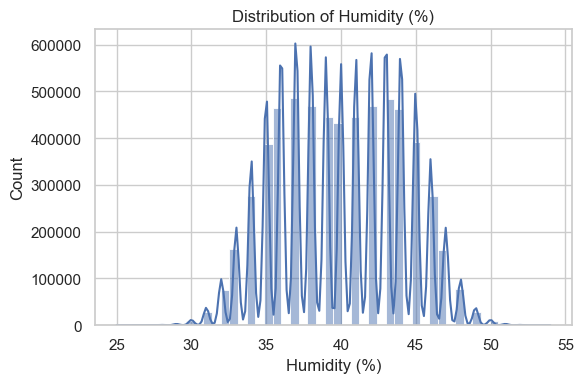

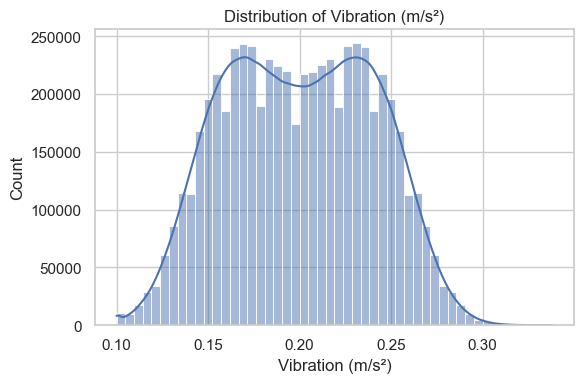

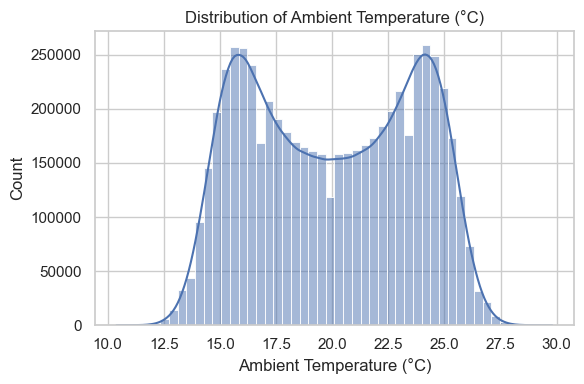

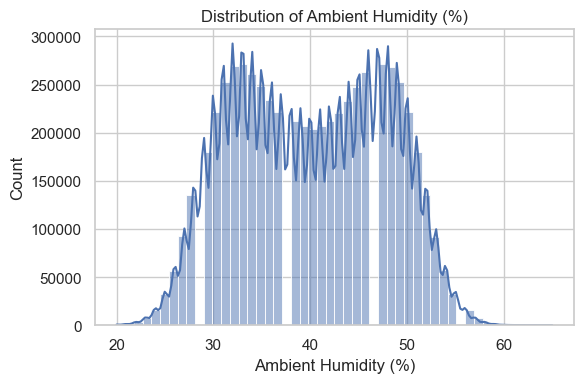

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

num_cols_to_plot = [
    "Voltage (V)", "Current (A)", "Temperature (°C)",
    "Power (W)", "Humidity (%)", "Vibration (m/s²)",
    "Ambient Temperature (°C)", "Ambient Humidity (%)"
]

for col in num_cols_to_plot:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col].dropna(), kde=True, bins=50)
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.show()


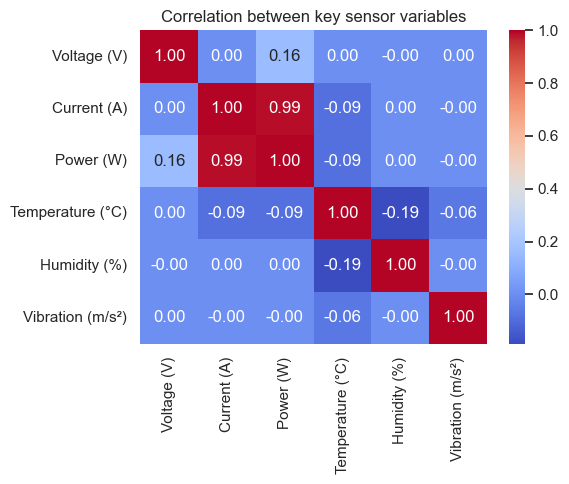

In [10]:
corr_cols = [
    "Voltage (V)", "Current (A)", "Power (W)",
    "Temperature (°C)", "Humidity (%)", "Vibration (m/s²)"
]
corr_cols = [c for c in corr_cols if c in df.columns]

corr = df[corr_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between key sensor variables")
plt.tight_layout()
plt.show()


In [11]:
# Fault rates
if "Fault Detected" in df.columns:
    print(df["Fault Detected"].value_counts(normalize=True))

if "Failure Type" in df.columns:
    print(df["Failure Type"].value_counts())

# Sensor-wise fault counts
if {"Sensor_ID", "Fault Detected"}.issubset(df.columns):
    fault_by_sensor = df.groupby("Sensor_ID")["Fault Detected"].sum().sort_values(ascending=False)
    print(fault_by_sensor.head(20))


Fault Detected
0    0.996714
1    0.003286
Name: proportion, dtype: float64
Failure Type
Overheating    9958
Overload       9913
Name: count, dtype: int64
Sensor_ID
S_314     15
S_1076    14
S_3398    13
S_2591    13
S_2351    12
S_3457    12
S_930     12
S_2408    12
S_3246    12
S_4133    12
S_3505    12
S_840     12
S_2856    12
S_4072    11
S_2442    11
S_3495    11
S_2241    11
S_28      11
S_1935    11
S_2414    11
Name: Fault Detected, dtype: int64


In [12]:
# Compare sensor behavior with vs without fault
fault_mask = (df["Fault Detected"] == 1)
no_fault_mask = (df["Fault Detected"] == 0)

cols_compare = ["Temperature (°C)", "Vibration (m/s²)", "Power (W)"]
for col in cols_compare:
    if col in df.columns:
        stats = df.groupby("Fault Detected")[col].describe()
        print(f"\n{col} by Fault Detected:\n", stats)



Temperature (°C) by Fault Detected:
                     count       mean       std   min   25%   50%   75%   max
Fault Detected                                                              
0               6028129.0  20.498804  1.040944  15.2  19.8  20.5  21.2  25.9
1                 19871.0  20.813417  1.027351  16.9  20.1  20.8  21.5  25.2

Vibration (m/s²) by Fault Detected:
                     count      mean       std    min    25%    50%    75%  \
Fault Detected                                                              
0               6028129.0  0.199733  0.040365  0.100  0.167  0.200  0.233   
1                 19871.0  0.283742  0.011039  0.256  0.276  0.282  0.290   

                  max  
Fault Detected         
0               0.336  
1               0.338  

Power (W) by Fault Detected:
                     count       mean        std   min   25%   50%   75%   max
Fault Detected                                                               
0               6028129.

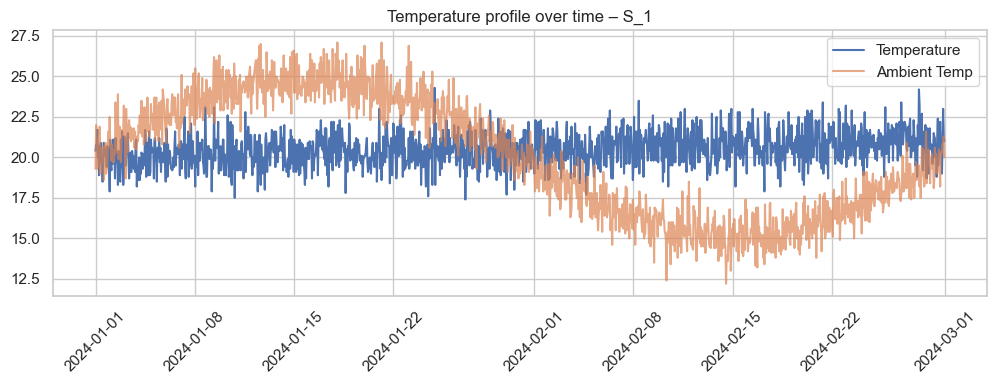

In [13]:
# Optional downsample for speed
sampled = df.sample(n=500_000, random_state=42) if len(df) > 500_000 else df

if {"Timestamp", "Sensor_ID"}.issubset(df.columns):
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    # Pick one sensor
    example_sensor = df["Sensor_ID"].iloc[0]
    ts = df[df["Sensor_ID"] == example_sensor].sort_values("Timestamp")

    plt.figure(figsize=(10, 4))
    plt.plot(ts["Timestamp"], ts["Temperature (°C)"], label="Temperature")
    plt.plot(ts["Timestamp"], ts["Ambient Temperature (°C)"], label="Ambient Temp", alpha=0.7)
    plt.legend()
    plt.title(f"Temperature profile over time – {example_sensor}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [14]:
import os
import numpy as np
import pandas as pd

# Load combined CSV (adjust path if needed)
folder_path = os.path.join(os.getcwd(), "sensor_data_1GB")
combined_path = os.path.join(folder_path, "sensor_maintenance_combined.csv")

df = pd.read_csv(combined_path, low_memory=False)

# Ensure proper types
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.sort_values(["Sensor_ID", "Timestamp"], inplace=True)

df.head()


,Sensor_ID,Timestamp,Voltage (V),Current (A),Temperature (°C),Power (W),Humidity (%),Vibration (m/s²),Equipment_ID,Operational Status,...,Ambient Temperature (°C),Ambient Humidity (%),External Factors,X,Y,Z,Equipment Relationship,Equipment Criticality,Fault Detected,Predictive Maintenance Trigger
0,S_1,2024-01-01 00:00:00,112,0.63,20.4,70.6,41.0,0.193,E_1,Operational,...,19.3,39.0,Clear Weather,26,14,21,Dependent,Medium,0,0
50,S_1,2024-01-01 01:00:00,113,0.47,20.8,53.1,40.0,0.190,E_1,Operational,...,22.0,43.0,Clear Weather,43,37,39,Independent,High,0,0
100,S_1,2024-01-01 02:00:00,111,0.48,20.5,53.3,38.0,0.204,E_1,Operational,...,21.3,43.0,Storm,2,18,20,Independent,High,0,0
150,S_1,2024-01-01 03:00:00,113,0.55,21.7,62.2,42.0,0.217,E_1,Operational,...,19.3,40.0,Storm,1,30,34,Independent,Medium,0,0
200,S_1,2024-01-01 04:00:00,113,0.54,20.0,61.0,41.0,0.250,E_1,Operational,...,21.2,44.0,Storm,3,25,6,Dependent,Medium,0,0


In [15]:
# Core numeric sensor columns
num_cols = [
    "Voltage (V)",
    "Current (A)",
    "Temperature (°C)",
    "Power (W)",
    "Humidity (%)",
    "Vibration (m/s²)",
    "Ambient Temperature (°C)",
    "Ambient Humidity (%)",
]

num_cols = [c for c in num_cols if c in df.columns]

# Work on a copy with multi-index for rolling by time per sensor
df_feat = df.set_index(["Sensor_ID", "Timestamp"]).sort_index()


In [16]:
import os
import pandas as pd
from glob import glob

folder_path = os.path.join(os.getcwd(), "sensor_data_1GB")

# Use the original chunk files, not the huge combined one
chunk_files = sorted(glob(os.path.join(folder_path, "sensor_maintenance_chunk_*.csv")))
print("Found", len(chunk_files), "chunk files")

# How many rows you want total for Phase 2 (tune to what your RAM can handle)
TARGET_ROWS = 500_000

sampled_dfs = []
rows_so_far = 0

for f in chunk_files:
    # Read each chunk in smaller pieces and sample
    for chunk in pd.read_csv(f, chunksize=100_000):
        remaining = TARGET_ROWS - rows_so_far
        if remaining <= 0:
            break

        frac = min(1.0, remaining / len(chunk))
        sample = chunk.sample(frac=frac, random_state=42)
        sampled_dfs.append(sample)
        rows_so_far += len(sample)

    if rows_so_far >= TARGET_ROWS:
        break

df = pd.concat(sampled_dfs, ignore_index=True)
print("Sampled rows:", len(df))


Found 84 chunk files


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\2730098151.py:19: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f, chunksize=100_000):
C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\2730098151.py:19: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f, chunksize=100_000):
C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\2730098151.py:19: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f, chunksize=100_000):
C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\2730098151.py:19: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f, chunksize=100_000):
C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\2730098151.py:19: DtypeWarning: Columns (11) have mixed types. Specify dty

Sampled rows: 500000


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\2730098151.py:19: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f, chunksize=100_000):


In [17]:
import numpy as np

df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.sort_values(["Sensor_ID", "Timestamp"], inplace=True)

num_cols = [
    "Voltage (V)", "Current (A)", "Temperature (°C)", "Power (W)",
    "Vibration (m/s²)"
]
num_cols = [c for c in num_cols if c in df.columns]

window_sizes = [6, 24]

def add_features_per_sensor(g):
    g = g.sort_values("Timestamp").copy()
    # rolling mean only
    for w in window_sizes:
        r = g[num_cols].rolling(window=w, min_periods=1)
        g[[f"{c}_mean_{w}" for c in num_cols]] = r.mean().values
    # lags and first diffs
    for c in num_cols:
        g[f"{c}_lag_1"] = g[c].shift(1)
        g[f"{c}_diff1"] = g[c].diff(1)
    return g

df_feat = df.groupby("Sensor_ID", group_keys=False).apply(add_features_per_sensor)

# Age feature
df_feat["age_hours"] = (
    df_feat.groupby("Sensor_ID")["Timestamp"]
           .transform(lambda x: (x - x.min()) / np.timedelta64(1, "h"))
)


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\1237179967.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df.groupby("Sensor_ID", group_keys=False).apply(add_features_per_sensor)


In [18]:
keep_cols = [
    "Sensor_ID", "Timestamp", "Fault Detected",
    # raw
    "Voltage (V)", "Current (A)", "Temperature (°C)", "Power (W)", "Vibration (m/s²)",
    # engineered examples
    "Temperature (°C)_mean_6", "Temperature (°C)_mean_24",
    "Vibration (m/s²)_mean_6", "Vibration (m/s²)_mean_24",
    "Temperature (°C)_lag_1", "Vibration (m/s²)_lag_1",
    "Temperature (°C)_diff1", "Vibration (m/s²)_diff1",
    "age_hours", "age_days", "delta_temp",
]

keep_cols = [c for c in keep_cols if c in df_feat.columns]
features = df_feat[keep_cols].copy()

features_path = os.path.join(folder_path, "sensor_features_sample.parquet")
features.to_parquet(features_path, index=False)
print("Saved compact features to:", features_path)


Saved compact features to: C:\Users\mihir\sensor_data_1GB\sensor_features_sample.parquet


In [19]:
H = 12  # or 24

features.sort_values(["Sensor_ID", "Timestamp"], inplace=True)
g = features.groupby("Sensor_ID")["Fault Detected"]
features["label_fault_next_12h"] = (
    g.shift(-H).rolling(H, min_periods=1).max().fillna(0).astype(int)
)

print(features["label_fault_next_12h"].value_counts(normalize=True))


label_fault_next_12h
0    0.96346
1    0.03654
Name: proportion, dtype: float64


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

data = features[features["label_fault_next_12h"].notna()].copy()

y = data["label_fault_next_12h"].astype(int)
X = data.drop(columns=["label_fault_next_12h", "Fault Detected", "Sensor_ID", "Timestamp"], errors="ignore")

X = X.dropna(axis=1, how="all")
X = X.loc[:, X.nunique() > 1]
X = X.fillna(method="ffill").fillna(method="bfill")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample"
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


C:\Users\mihir\AppData\Local\Temp\ipykernel_30564\2944299611.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill").fillna(method="bfill")


              precision    recall  f1-score   support

           0       1.00      0.74      0.85     96346
           1       0.12      0.93      0.22      3654

    accuracy                           0.75    100000
   macro avg       0.56      0.84      0.53    100000
weighted avg       0.96      0.75      0.83    100000

ROC-AUC: 0.8935486872022361
